In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Open the pickle file and load the data for the first subject
with open('benchmarks/benchmarks/MOABB/data/MOABB_pickled/BNCI2014-001/0125_001-040/sub-001.pkl', 'rb') as f:
    data = pickle.load(f)

data

{'code': 'BNCI2014-001',
 'subject_list': [1, 2, 3, 4, 5, 6, 7, 8, 9],
 'paradigm': 'imagery',
 'n_sessions': 2,
 'fmin': 1,
 'fmax': 40,
 'ival': [2, 6],
 'interval': [0, 4],
 'reference': '10.3389/fnins.2012.00055',
 'event_id': {'left_hand': 1, 'right_hand': 2, 'feet': 3, 'tongue': 4},
 'events': ['left_hand', 'right_hand', 'feet', 'tongue'],
 'original_srate': 250,
 'srate': 125,
 'channels': ['Fz',
  'FC3',
  'FC1',
  'FCz',
  'FC2',
  'FC4',
  'C5',
  'C3',
  'C1',
  'Cz',
  'C2',
  'C4',
  'C6',
  'CP3',
  'CP1',
  'CPz',
  'CP2',
  'CP4',
  'P1',
  'Pz',
  'P2',
  'POz'],
 'adjacency_mtx': array([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0

In [4]:
X, y, y_labels = data['x'], data['y'], data['labels']

In [5]:
X.shape

(576, 22, 500)

In [6]:
type(X)

numpy.ndarray

(12 trials/'class 1: left hand' + 12 trials/'class 2: right hand' + 12 trials/'class 3: both feet' + 12 trials/'class 4: tongue')/run x 6 runs/session x 2 sessions = 576 trials


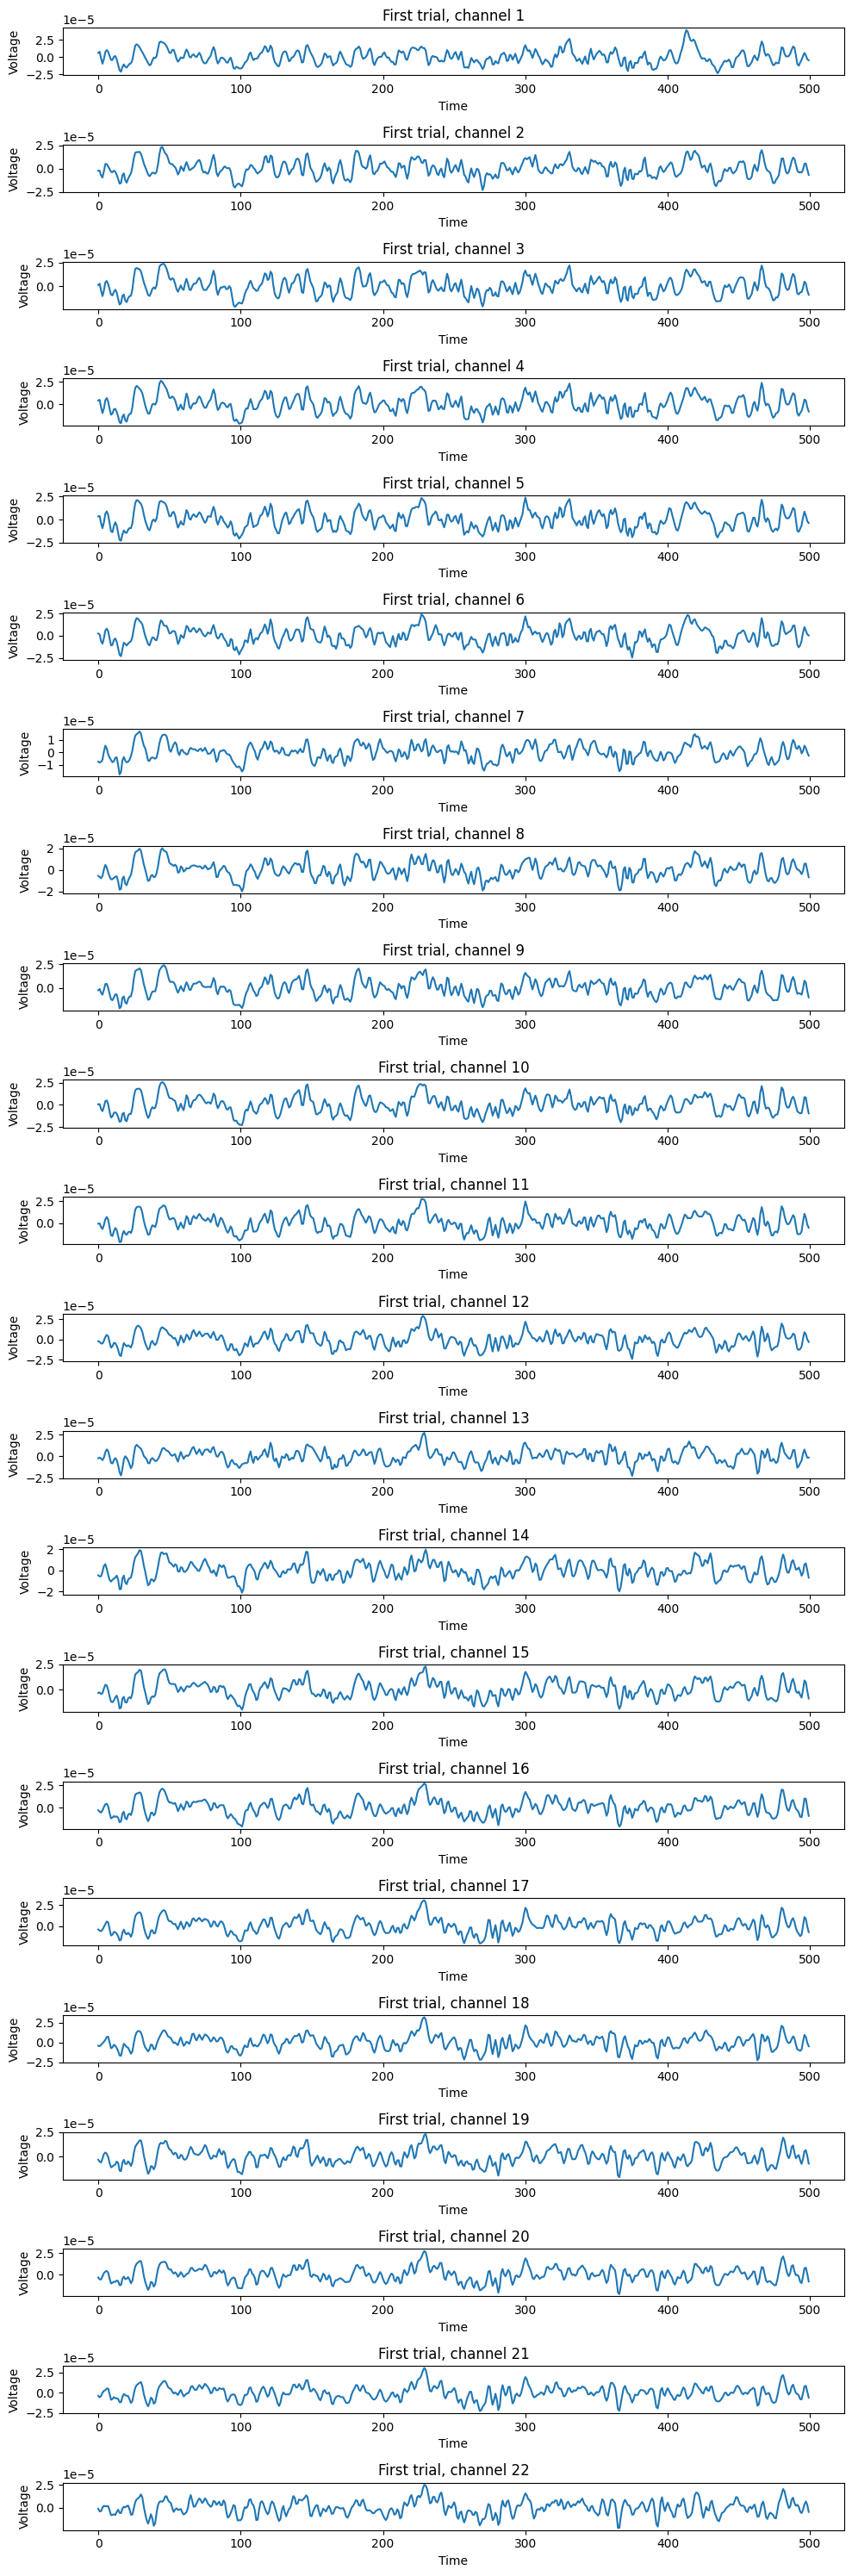

In [7]:
# Create a new figure with a larger size
num_trials   = X.shape[0]
num_channels = X.shape[1]

fig, axs = plt.subplots(nrows=22, figsize=(10, 30))

# Plot the time series for each channel
for i in range(num_channels):
    axs[i].plot(X[0, i])
    axs[i].set_title(f'First trial, channel {i+1}')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Voltage')

# Show the plot
plt.tight_layout()
plt.show()

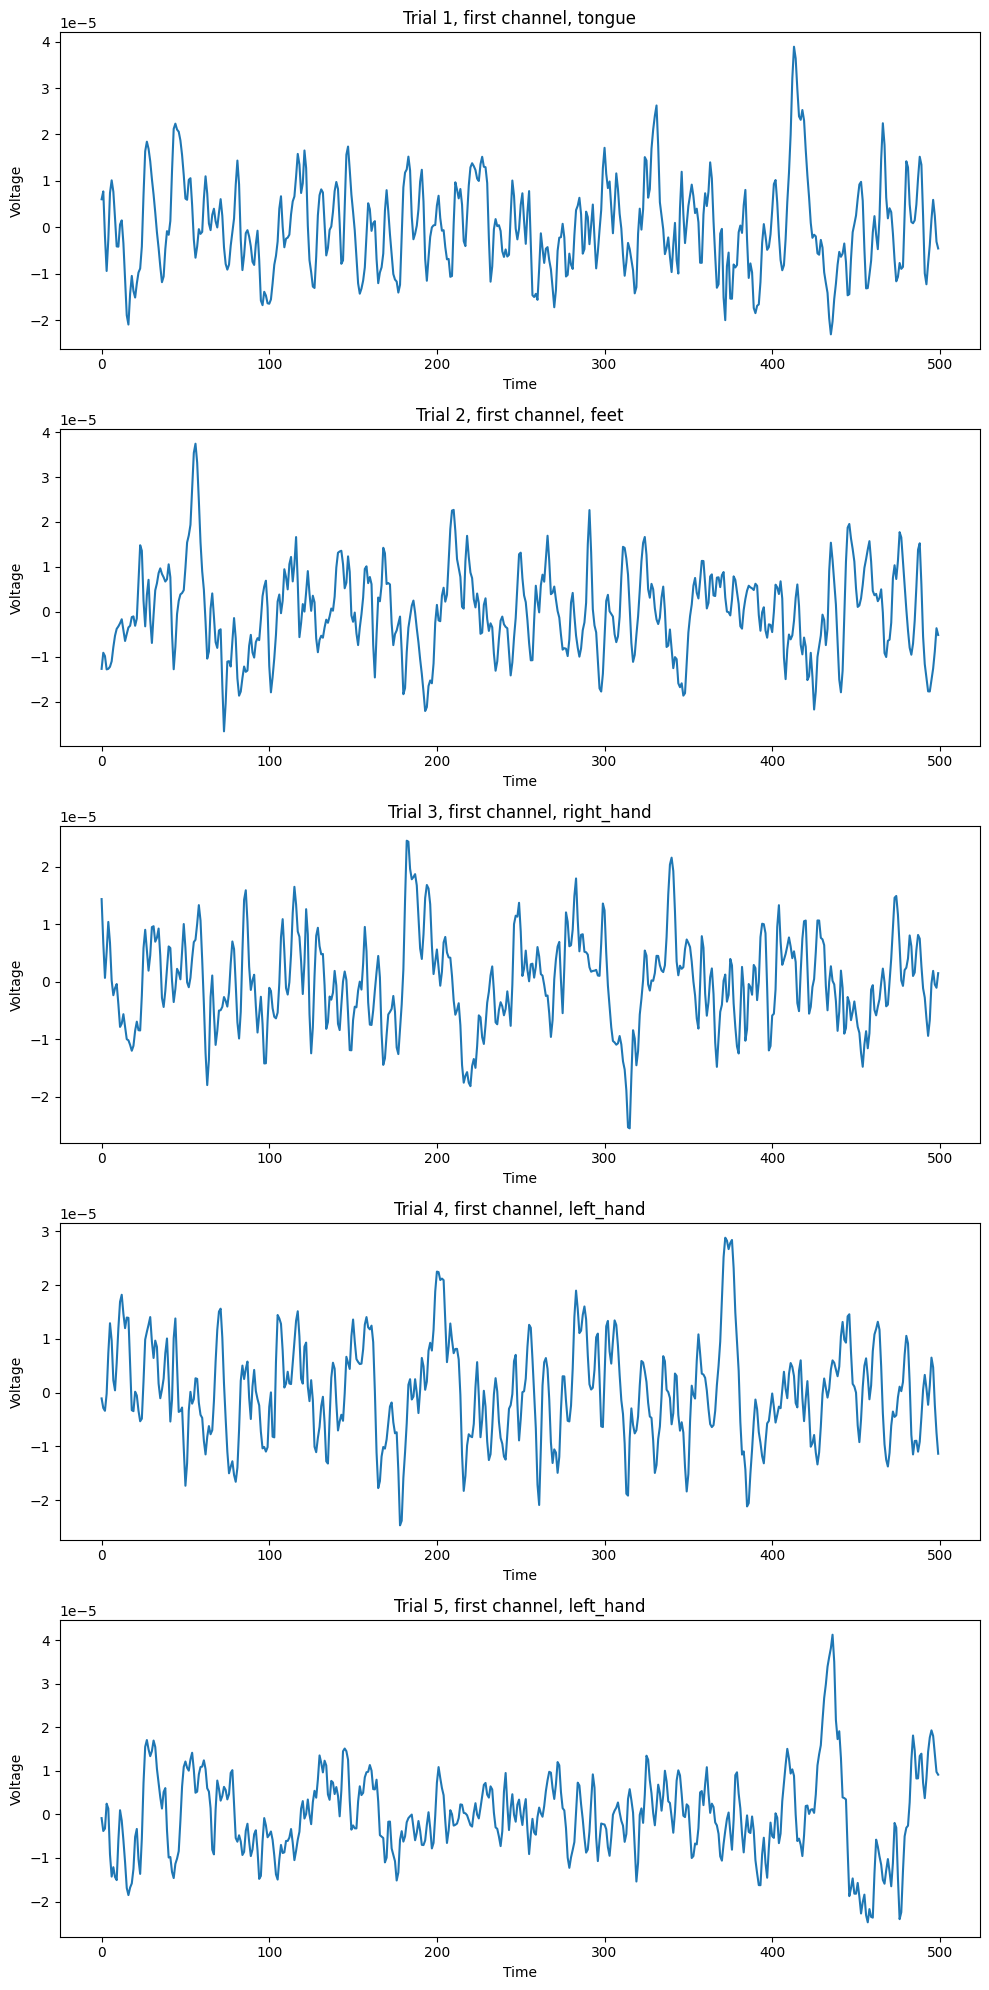

In [9]:
trials_to_plot = 5

fig, axs = plt.subplots(nrows=trials_to_plot, figsize=(10, 20))

# Plot the time series for each channel
for i in range(num_trials)[:trials_to_plot]:
    label = y_labels[i]
    axs[i].plot(X[i, 0])
    axs[i].set_title(f'Trial {i+1}, first channel, {label}')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Voltage')

# Show the plot
plt.tight_layout()

In [26]:
import mne
from mne.preprocessing import ICA
%pip install python-picard

# get the first trial
first_trial = X[0]

# raw object settings
n_channels = first_trial.shape[0]
ch_types = ['eeg'] * n_channels  # all channels are EEG
ch_names = [f'channel {i+1}' for i in range(n_channels)]

# create a raw object
info = mne.create_info(ch_names=ch_names, sfreq=125, ch_types=ch_types) # sampling frequency (rate) is 125 Hz as per the dataset description
raw  = mne.io.RawArray(first_trial, info)

# Apply ICA for artifact removal
ica = ICA(n_components=20, random_state=97, max_iter=10000, method='picard')

# preprocess the raw data
raw.filter(1., None)                                                 # band-pass filter
# raw.info['bads'] = find_bad_channels_maxwell(raw)                   # find and mark bad channels
# raw.interpolate_bads()                                              # interpolate bad channels
raw._data = (raw._data - np.mean(raw._data)) / np.std(raw._data)    # normalize the data

# fit the ICA
ica.fit(raw)
ica.exclude = [0]  # assuming component 0 is an artifact
raw = ica.apply(raw.copy())

# Re-reference to the average
raw.set_eeg_reference('average')

# Normalize the data (optional)
raw._data = (raw._data - np.mean(raw._data)) / np.std(raw._data)

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Creating RawArray with float64 data, n_channels=22, n_times=500
    Range : 0 ... 499 =      0.000 ...     3.992 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 413 samples (3.304 s)

Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 22 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


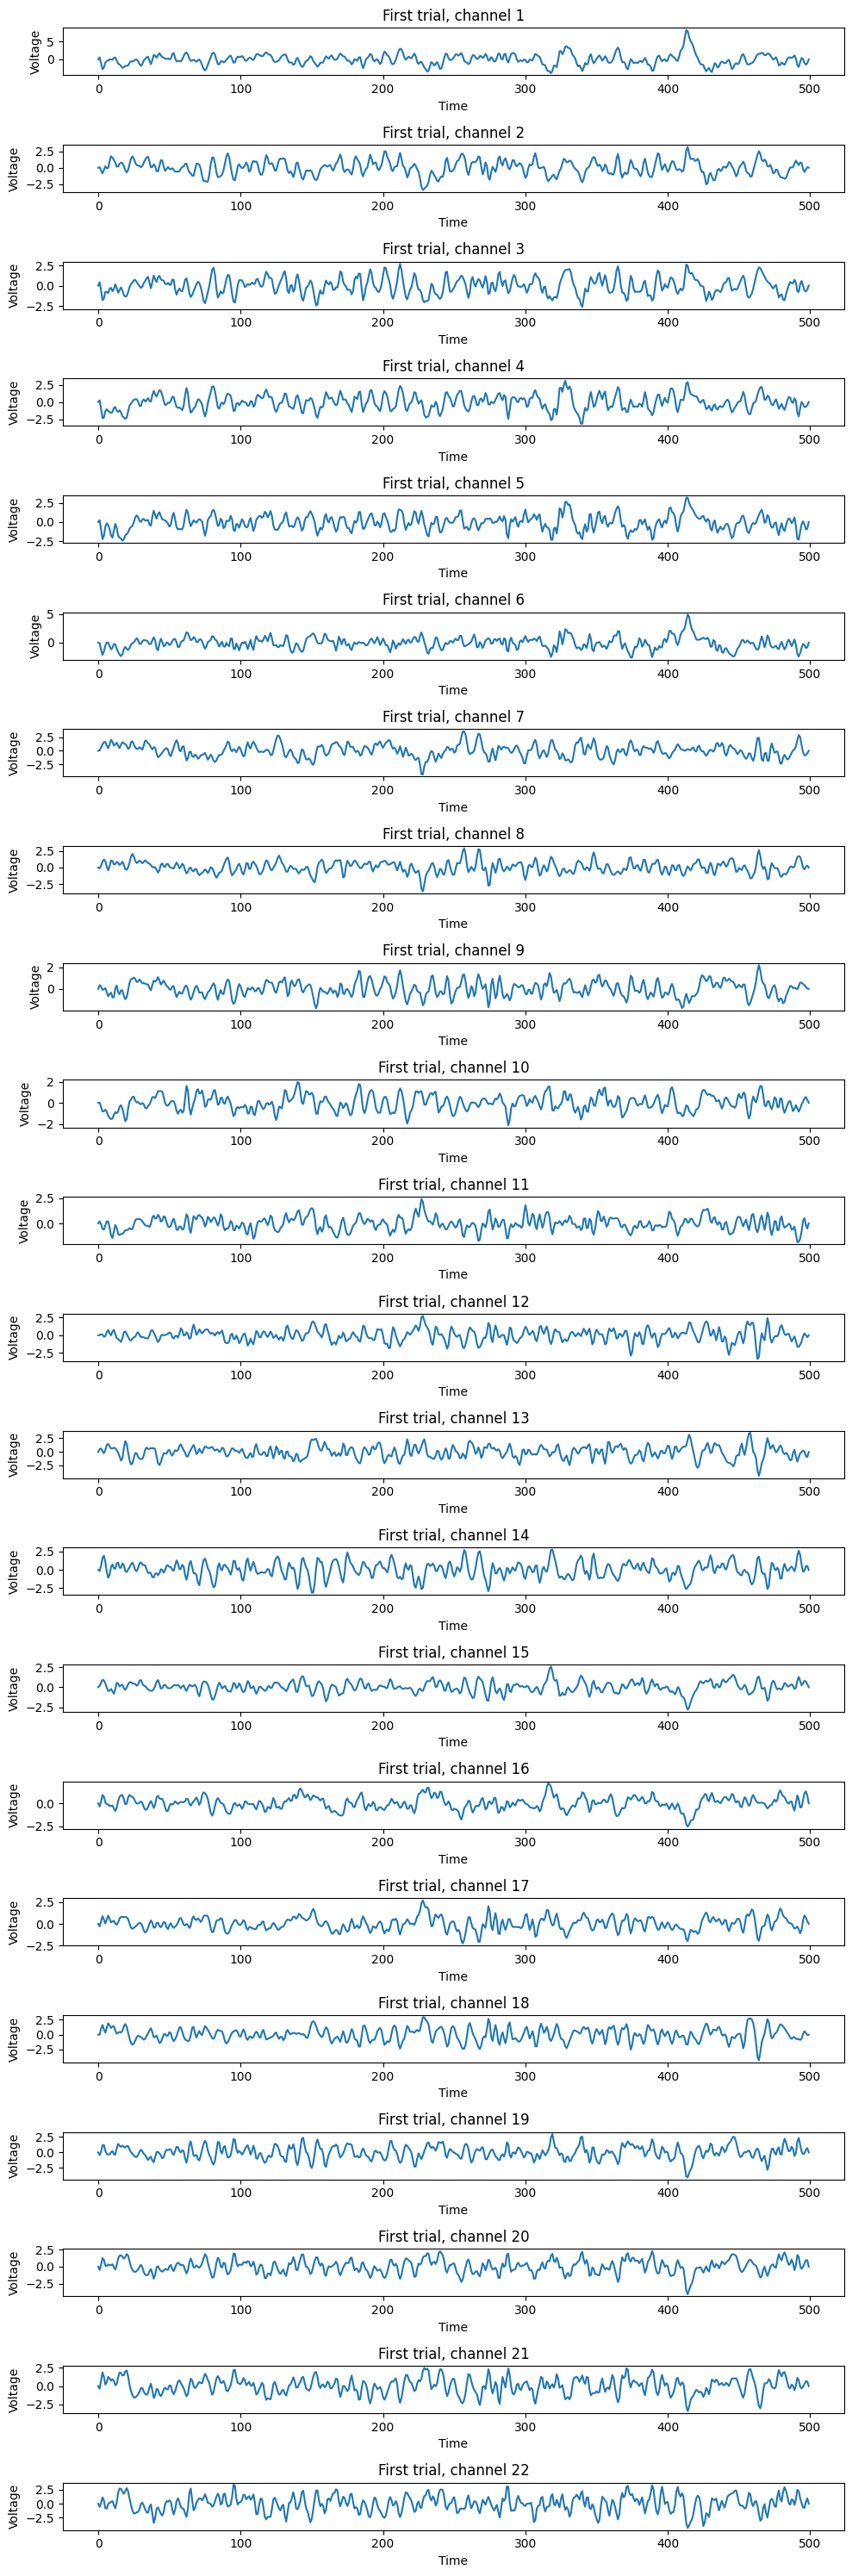

In [32]:
cleaned_first_trial = raw.get_data()

num_channels = cleaned_first_trial.shape[0]

fig, axs = plt.subplots(nrows=22, figsize=(10, 30))

# Plot the time series for each channel
for i in range(num_channels):
    axs[i].plot(cleaned_first_trial[i])
    axs[i].set_title(f'First trial, channel {i+1}')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Voltage')

# Show the plot
plt.tight_layout()
# plt.show()